In [1]:
import pandas as pd
import numpy as np
import qiskit.pulse as pulse
from qiskit.circuit import Parameter
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit import schedule
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend

In [2]:
backend = SingleTransmonTestBackend(5.2e9,-.25e9, 1e9, 0.8e9, noise=False)
qubit = 0
cals=Calibrations.from_backend(backend)
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
Multi qubit instructions:
)>


In [3]:
# A function to instantiate calibrations and add a couple of template schedules.
def setup_cals(backend) -> Calibrations:

    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)

    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp, num_qubits=1)
    cals.add_schedule(xm, num_qubits=1)
    cals.add_schedule(x90p, num_qubits=1)

    return cals

# Add guesses for the parameter values to the calibrations.
def add_parameter_guesses(cals: Calibrations):

    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)


In [4]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [5]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = Calibrations.from_backend(backend, libraries=[library])
print(library.default_values()) # check what parameter values this library has
print(cals.get_inst_map()) # check the new cals's InstructionScheduleMap made from the library
print(cals.get_schedule('x',(0,))) # check one of the schedules built from the new calibration

[DefaultCalValue(value=0.5, parameter='amp', qubits=(), schedule_name='x'), DefaultCalValue(value=0.0, parameter='β', qubits=(), schedule_name='x'), DefaultCalValue(value=320, parameter='duration', qubits=(), schedule_name='x'), DefaultCalValue(value=80.0, parameter='σ', qubits=(), schedule_name='x'), DefaultCalValue(value=0.0, parameter='β', qubits=(), schedule_name='sx'), DefaultCalValue(value=320, parameter='duration', qubits=(), schedule_name='sx'), DefaultCalValue(value=80.0, parameter='σ', qubits=(), schedule_name='sx'), DefaultCalValue(value=0.25, parameter='amp', qubits=(), schedule_name='sx')]
<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'sx', 'y', 'sy'}
Multi qubit instructions:
)>
ScheduleBlock(Play(Drag(duration=320, amp=(0.5+0j), sigma=80, beta=0), DriveChannel(0)), name="x", transform=AlignLeft())


In [6]:
from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal


In [7]:
columns_to_show = ["parameter", "qubits", "schedule", "value", "date_time"]
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,duration,(),sx,3.200000e+02,2023-03-13 16:51:48.817003+0530
1,duration,(),x,3.200000e+02,2023-03-13 16:51:48.816855+0530
2,β,(),sx,0.000000e+00,2023-03-13 16:51:48.816955+0530
3,drive_freq,"(0,)",None,5.200000e+09,2023-03-13 16:51:49.108984+0530
4,σ,(),sx,8.000000e+01,2023-03-13 16:51:48.817021+0530
5,amp,(),sx,2.500000e-01,2023-03-13 16:51:48.817034+0530
6,β,(),x,0.000000e+00,2023-03-13 16:51:48.816823+0530
7,amp,(),x,5.000000e-01,2023-03-13 16:51:48.816730+0530
8,σ,(),x,8.000000e+01,2023-03-13 16:51:48.816890+0530


In [8]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = RoughFrequencyCal(qubit, cals, frequencies, backend=backend)
spec.set_experiment_options(amp=0.005)

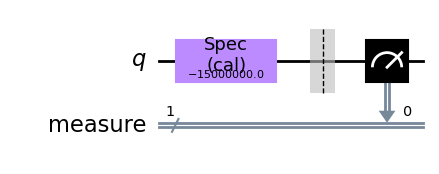

In [9]:
circuit = spec.circuits()[0]
circuit.draw(output="mpl")

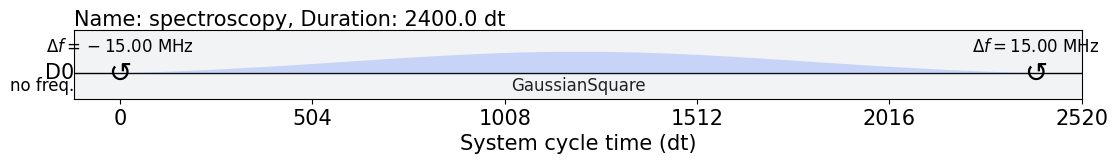

In [10]:
next(iter(circuit.calibrations["Spec"].values())).draw() # let's check the schedule

/home/rupeshknn/mambaforge/envs/exp/lib/python3.8/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


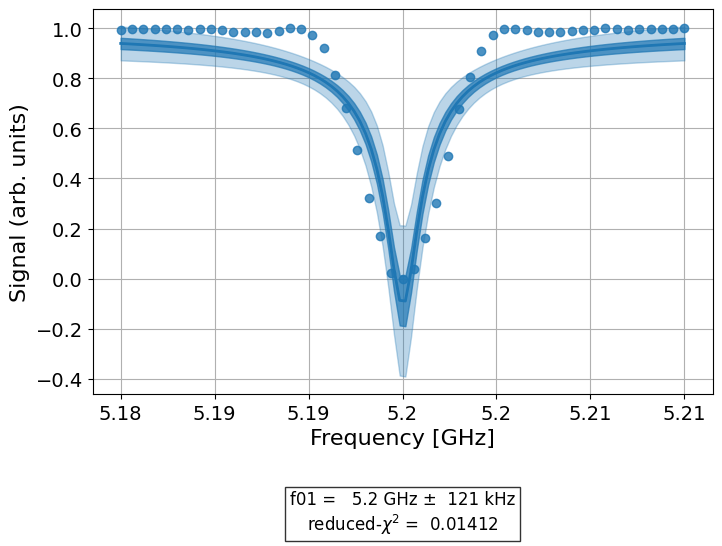

In [11]:
spec_data = spec.run().block_for_results()
spec_data.figure(0)

In [12]:
print(spec_data.analysis_results("f01"))


AnalysisResult
- name: f01
- value: (5.20001+/-0.00012)e+09
- χ²: 0.014122387142534451
- quality: good
- extra: <1 items>
- device_components: ['Q0']
- verified: False


In [13]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit]))[columns_to_show]


,parameter,qubits,schedule,value,date_time
0,drive_freq,"(0,)",None,5.200006e+09,2023-03-13 16:53:21.636117+0530


In [14]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal
rabi = RoughXSXAmplitudeCal(qubit, cals, backend=backend, amplitudes=np.linspace(-0.1, 0.1, 51))

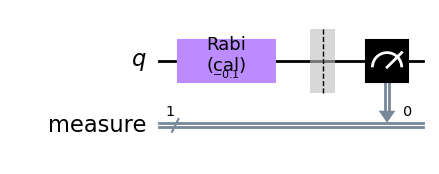

In [15]:
rabi.circuits()[0].draw("mpl")


/home/rupeshknn/mambaforge/envs/exp/lib/python3.8/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


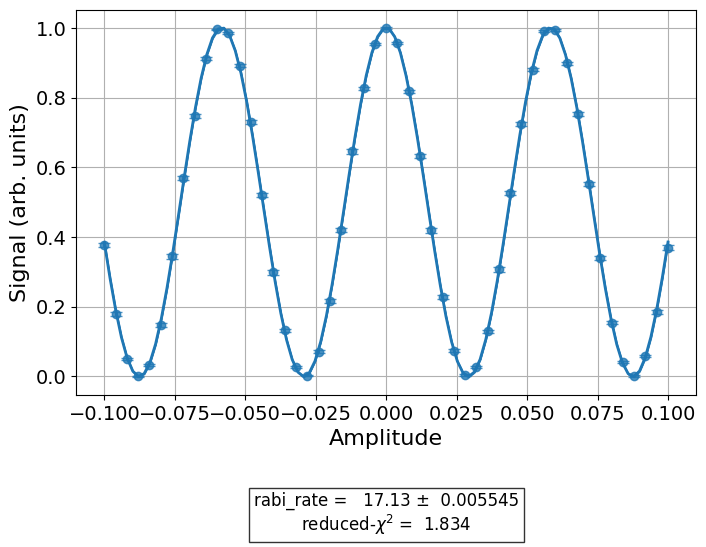

In [16]:
rabi_data = rabi.run().block_for_results()
rabi_data.figure(0)

In [17]:
print(rabi_data.analysis_results("rabi_rate"))


AnalysisResult
- name: rabi_rate
- value: 17.129+/-0.006
- χ²: 1.8337542775567155
- quality: bad
- device_components: ['Q0']
- verified: False


In [18]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,(),sx,0.250000+0.000000j,2023-03-13 16:51:48.817034+0530
1,amp,(),x,0.500000+0.000000j,2023-03-13 16:51:48.816730+0530
2,amp,"(0,)",sx,0.014595+0.000000j,2023-03-13 16:53:50.227314+0530
3,amp,"(0,)",x,0.029190+0.000000j,2023-03-13 16:53:50.219776+0530


In [19]:
(cals.get_schedule("x", qubit),
cals.get_schedule("sx", qubit),
cals.get_schedule("y", qubit))


(ScheduleBlock(Play(Drag(duration=320, amp=(0.02919024+0j), sigma=80, beta=0), DriveChannel(0)), name="x", transform=AlignLeft()),
 ScheduleBlock(Play(Drag(duration=320, amp=(0.01459512+0j), sigma=80, beta=0), DriveChannel(0)), name="sx", transform=AlignLeft()),
 ScheduleBlock(Play(Drag(duration=320, amp=0.02919024j, sigma=80, beta=0), DriveChannel(0)), name="y", transform=AlignLeft()))

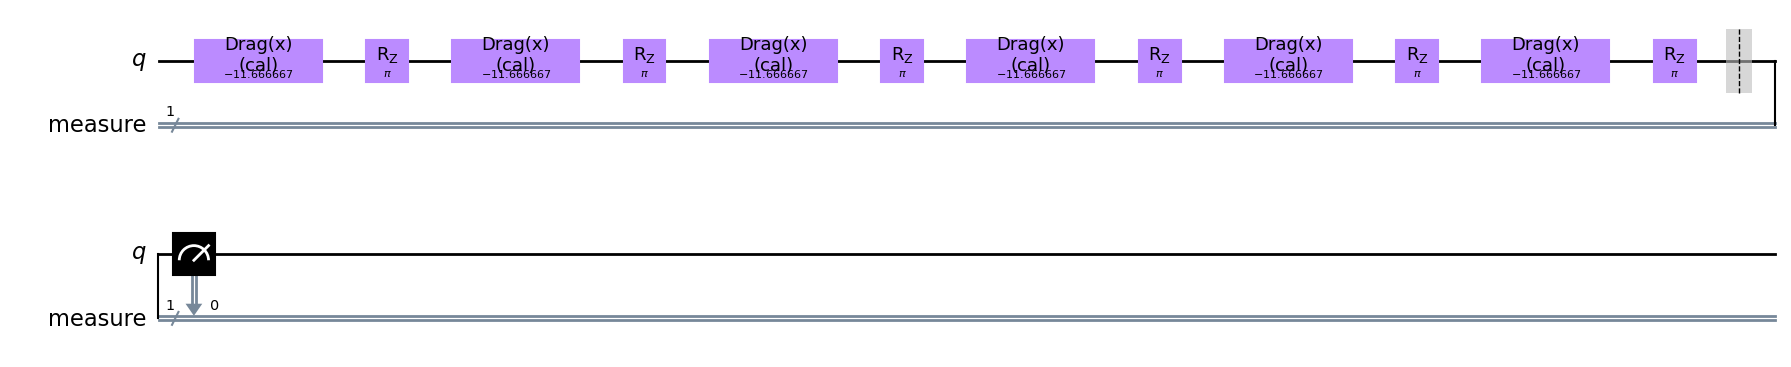

In [20]:
from qiskit_experiments.library import RoughDragCal
cal_drag = RoughDragCal(qubit, cals, backend=backend, betas=np.linspace(-20, 20, 25))
cal_drag.set_experiment_options(reps=[3, 5, 7])
cal_drag.circuits()[5].draw(output='mpl')

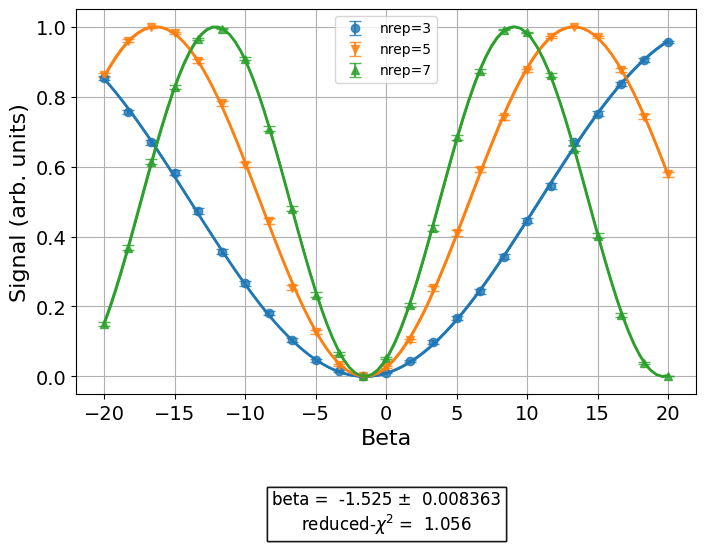

In [21]:
drag_data = cal_drag.run().block_for_results()
drag_data.figure(0)

In [22]:
print(drag_data.analysis_results("beta"))

AnalysisResult
- name: beta
- value: -1.525+/-0.008
- χ²: 1.0562213227738841
- quality: bad
- device_components: ['Q0']
- verified: False


In [23]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,β,"(0,)",x,-1.525475,2023-03-13 16:54:04.300337+0530
1,β,(),sx,0.000000,2023-03-13 16:51:48.816955+0530
2,β,(),x,0.000000,2023-03-13 16:51:48.816823+0530


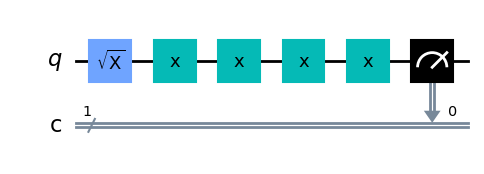

In [24]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitudeCal
amp_x_cal = FineXAmplitudeCal(qubit, cals, backend=backend, schedule_name="x")
amp_x_cal.circuits()[5].draw(output="mpl")

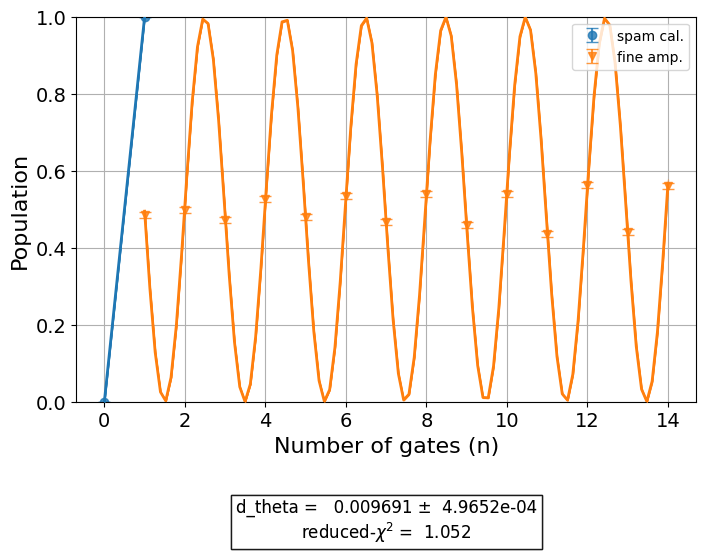

In [25]:
data_fine = amp_x_cal.run().block_for_results()
data_fine.figure(0)

In [26]:
print(data_fine.analysis_results("d_theta"))


AnalysisResult
- name: d_theta
- value: 0.0097+/-0.0005
- χ²: 1.0523339798246343
- quality: good
- device_components: ['Q0']
- verified: False


In [27]:
dtheta = data_fine.analysis_results("d_theta").value.nominal_value
target_angle = np.pi
scale = target_angle / (target_angle + dtheta)
pulse_amp = cals.get_parameter_value("amp", qubit, "x")
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.010 rad.
Thus, scale the 0.0291+0.0000j pulse amplitude by 0.997 to obtain 0.02901+0.00000j.


In [28]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,(),sx,0.250000+0.000000j,2023-03-13 16:51:48.817034+0530
1,amp,(),x,0.500000+0.000000j,2023-03-13 16:51:48.816730+0530
2,amp,"(0,)",sx,0.014595+0.000000j,2023-03-13 16:53:50.227314+0530
3,amp,"(0,)",x,0.029100+0.000000j,2023-03-13 16:54:06.369209+0530


To check that we have managed to reduce the error in the rotation angle we will run the fine amplitude calibration experiment once again.

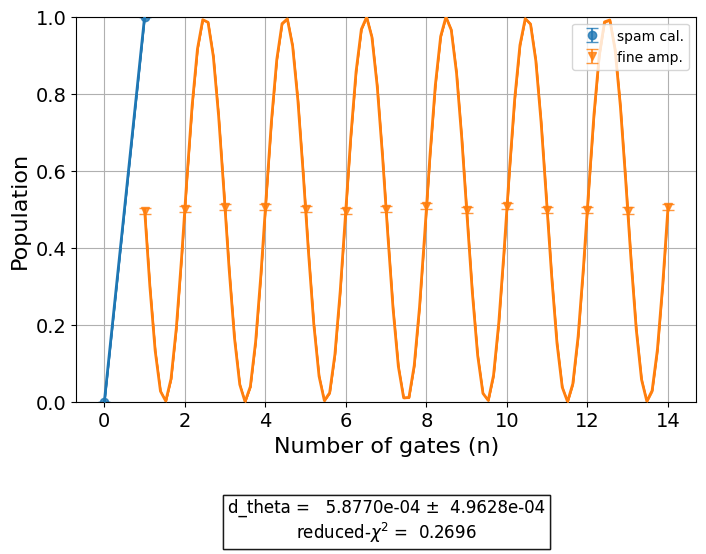

In [29]:
data_fine2 = amp_x_cal.run().block_for_results()
data_fine2.figure(0)

In [30]:
print(data_fine2.analysis_results("d_theta"))


AnalysisResult
- name: d_theta
- value: 0.0006+/-0.0005
- χ²: 0.26962438171718506
- quality: good
- device_components: ['Q0']
- verified: False
